# Assignment #1 - Linear Regression

<font color="red"> <b> Due: Sep 24 (Tuesday) 11:00 pm </b> </font>

<font color="blue"> Sagar Satyanarayana </font>

# Introduction

Objective: to derive a linear regression model using Least Squares and Least Mean Squares to predict house sale prices for King County including Seattle. The dataset includes homes sold between May 2014 and May 2015.

# Data

The data was obtained from https://www.kaggle.com/harlfoxem/housesalesprediction.
The dataset contains 21 columns. The "price" column is the dependent variable and the model is used to predict this, given other 20 independent variables.

The columns(independent features) "id" and "date" are removed from the model as they have very little information useful in predicting the "price". This can be seen in the correlation matrix, the correlation matrix indicates which independent features are correlated with the response("price"), negative correlation indicates that an increase in those features will decrease our response.

The dataset is split into training and testing data with 70:30 split.
The independent variables are normalized using mean normalization (specific to each feature (column-wise)).

In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv(r'''C:\Users\sagar\Downloads\ITCS-6156-Assignment\housesalesprediction\kc_house_data.csv''')

In [2]:
len(data.columns)

21

In [3]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [4]:
data["date"] = pd.to_datetime(data["date"])

In [5]:
corr_matrix = data.corr()
corr_matrix["price"].sort_values()

zipcode         -0.053203
id              -0.016762
long             0.021626
condition        0.036362
yr_built         0.054012
sqft_lot15       0.082447
sqft_lot         0.089661
yr_renovated     0.126434
floors           0.256794
waterfront       0.266369
lat              0.307003
bedrooms         0.308350
sqft_basement    0.323816
view             0.397293
bathrooms        0.525138
sqft_living15    0.585379
sqft_above       0.605567
grade            0.667434
sqft_living      0.702035
price            1.000000
Name: price, dtype: float64

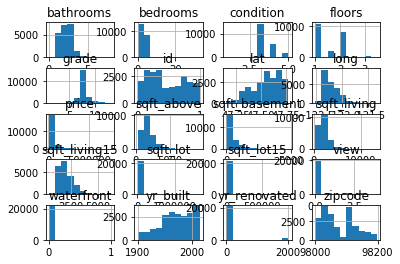

<Figure size 14400x25200 with 0 Axes>

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
data.hist()
plt.figure(figsize=(200,350))
plt.show()

In [7]:
import numpy as np
def split_train_test(data, test_ratio, seed):
    np.random.seed(seed)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [8]:
data_train, data_test = split_train_test(data, 0.3, 1)

In [9]:
data_train_independent = data_train.drop(columns=["price","date","id"])
data_train_dependent = data_train[["price"]]
data_test_independent = data_test.drop(columns=["price","date","id"])
data_test_dependent = data_test[["price"]]

In [10]:
data_train_independent = (data_train_independent-data_train_independent.mean())/data_train_independent.std()
data_test_independent = (data_test_independent-data_test_independent.mean())/data_test_independent.std()

In [11]:
T_train = data_train_dependent.to_numpy()
X_train = data_train_independent.to_numpy()

In [12]:
T_test = data_test_dependent.to_numpy()
X_test = data_test_independent.to_numpy()

# Method

 - Review of the linear models: Linear model can be defined as a Euclidean dot product between two vectors.
 $$
     f(x;w) = w^{\intercal} x = \sum_{0}^{D}w_{i}x_{i} \\
             = w_{0}x_{0}+w_{1}x_{1}+ \dots +w_{D}x_{D}
 $$
 
    - Least Squares (LS) method to compute weights: used in batch training, weight parameter that gives the best fit is;
    $$
        w^{*} = arg \quad min_{w} \sum_{i=1}^{N} (f(x_{i};w)-t_{i})^{2} 
    $$ 
    The above equation when solved analytically by settting the derivative of $w$ to zero, we get;
    $$
          w = (X^{\intercal}X)^{-1}X^{\intercal}T
    $$
    
    - Least Mean Squares (LMS) method to compute weights: Generally used in online training, the learning is sequential ie., data is trained one point at a time using an update function $\alpha$ called as stochastic gradient descent.
    $$
        w^{(k+1)} = w^{(k)} - \alpha \nabla E_{k}
    $$
    
    The update rule for each sample is give by;
    
    $$
        w^{(k+1)} = w^{k} - \alpha (w^{(k)^\intercal} x_{k} - t_{k}) x_{k}
    $$

 
 
- Implementation of Linear Model: 
    - The class LinearModel is used to compute the weights and the computed weights during training are inturn used to predict house prices of a linear system $Ax+b=c$ using both Least Squares and Least Mean Squares.
    - Method _check_matrix: makes sure the input matrix is in the required dimension.
    - Adding bias: A bias column $w_{0}$ with ones are added to the weights during training.
    - Computing weights: The weights are computed using two methods Least squares and Least mean squares reviewed above.
    - Using the model: The weights computed using the training data is used to predict the "price" of new data using $\hat{y} = X W$, where $\hat{y}$ is the predicted value and $W$ is the weight computed in the training step.


### Super Classs Definition

In [13]:
import numpy as np 
from abc import ABC, abstractmethod

# Super class for machine learning models 

class BaseModel(ABC):
    """ Super class for ITCS Machine Learning Class"""
    
    @abstractmethod
    def train(self, X, T):
        pass

    @abstractmethod
    def use(self, X):
        pass

    
class LinearModel(BaseModel):
    """
        Abstract class for a linear model 
        
        Attributes
        ==========
        w       ndarray
                weight vector/matrix
    """

    def __init__(self):
        """
            weight vector w is initialized as None
        """
        
#         self.X = variables
#         self.T = targets
        self.w = None
        

    # check if the matrix is 2-dimensional. if not, raise an exception    
    def _check_matrix(self, mat, name):
        if len(mat.shape) != 2:
            raise ValueError(''.join(["Wrong matrix ", name]))
        
    # add a basis
    def add_ones(self, X):
        """
            add a column basis to X input matrix
        """
        self._check_matrix(X, 'X')
        return np.hstack((np.ones((X.shape[0], 1)), X))

    ####################################################
    #### abstract funcitons ############################
    @abstractmethod
    
    def train(self, X, T):
        """
            train linear model
            
            parameters
            -----------
            X     2d array
                  input data
            T     2d array
                  target labels
        """        
        
        X = self.add_ones(X)
        
        w = np.linalg.inv(X.T @ X) @ X.T @ T 
        
        
        
        
    
    @abstractmethod
    def use(self, X):
        """
            apply the learned model to input X
            
            parameters
            ----------
            X     2d array
                  input data
            
        """        
        y = X @ self.W
        
        return y

### Least Squares

In [14]:
# Linear Regression Class for least squares
class LinearRegress(LinearModel): 
    """ 
        LinearRegress class 
        
        attributes
        ===========
        w    nd.array  (column vector/matrix)
             weights
    """
    def __init__(self):
        LinearModel.__init__(self)
        
    # train lease-squares model
    
    def train(self, X, T):
        T_temp = T
        X = self.add_ones(X=X)
        
        self.w = np.linalg.inv(X.T @ X) @ X.T @ T_temp ## TODO: replace this with your codes
            
    
    # apply the learned model to data X
    def use(self, X):
        X = self.add_ones(X)
        return X @ self.w  ## TODO: replace this with your codes
    
    def weights(self):
        return self.w    

        

### Least Mean Squares

In [15]:
import collections # for checking iterable instance

# LMS class 
class LMS(LinearModel):
    """
        Lease Mean Squares. online learning algorithm
    
        attributes
        ==========
        w        nd.array
                 weight matrix
        alpha    float
                 learning rate
    """
    def __init__(self, alpha):
        LinearModel.__init__(self)
        self.alpha = alpha
         
    
    # batch training by using train_step function
    def train(self, X, T):
        X1 = self.add_ones(X)
        
        if self.w is None:
            self.w = np.zeros(X1.shape[1])
#             self.w = np.random.rand(X1.shape[1])

        
        for k in range(X1.shape[0]):             
            self.w = self.train_step(X[k], T[k])
            
#             print(self.w)
#             print(k)
        
        
    # train LMS model one step 
    # here the x is 1d vector
    def train_step(self, x, t):
        x1 = np.concatenate([[1], x])
        if self.w is None:
            self.w = np.zeros(x1.shape[0])

        self.w = self.w - (self.alpha * (((self.w.T @ x1) - t) *x1))
        return self.w
  

    def weights(self):
        return self.w
    
    
    # apply the current model to data X
    def use(self, X):
        X1 = self.add_ones(X)
        s = np.reshape((X1@self.w), (-1,1))
        return s
        
         

### Usage Examples

In [16]:
# HERE follow are for my code tests.

import matplotlib.pyplot as plt
%matplotlib inline

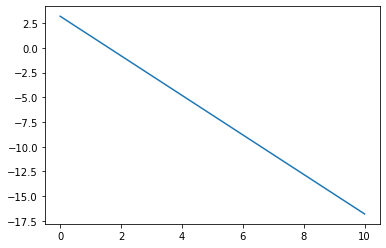

In [17]:
X = np.linspace(0,10, 11).reshape((-1, 1))
T = -2 * X + 3.2

ls = LinearRegress()

ls.train(X, T)

plt.plot(ls.use(X))

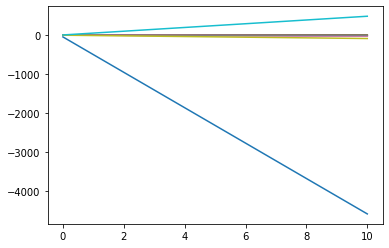

In [18]:
lms = LMS(0.1)
for x, t in zip(X, T):
    lms.train_step(x, t)
    plt.plot(lms.use(X))

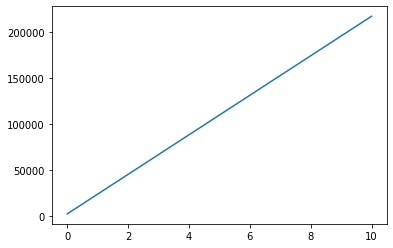

In [19]:
lms.train(X, T)
plt.plot(lms.use(X))

# Experiments




## Least squares implementation to predict house prices

The below implementation using Least Squares method to predict the house prices. The model is trained using training datasets X_train and T_train. X_train contains all independent variables used in the prediction of "price" and T_train contains the dependent variable ("price") for the corresponding independent variables. The train step is used to compute the weights using the training data.
The .use() method is used to predict "price" using independent variables from X_test dataset.

## Least Mean Squares implementation to predict house prices

Least Mean Squares method uses similar steps. One major difference is that, learning in LMS method takes place sequentially ie., the points in the training dataset are used one by one to compute weights using stochastic gradient descent. Once the weights are computed after going through all the training data sequentially the model can be used to predict the "price".

The predicted values using LS is stored in pred_ls and the predicted values using LMS model is stored in pred_lms.

In [20]:
ls = LinearRegress()
ls.train(X=X_train, T=T_train)
pred_ls = ls.use(X_test)
pred_ls

array([[ 617877.28433932],
       [ 509306.26594603],
       [ 676309.52217891],
       ...,
       [ 297879.95313929],
       [ 342424.928317  ],
       [2050363.87337837]])

In [21]:
lms = LMS(alpha = 0.001)
lms.train(X_train, T_train)
temp_w = lms.weights()
pred_lms = lms.use(X_test)
pred_lms


array([[ 674667.17308019],
       [ 437597.89219824],
       [ 628379.09005677],
       ...,
       [ 262731.0145851 ],
       [ 258253.83313498],
       [2599255.50623565]])

# Visualization of the results

Predictions from both LS and LMS model are plotted against the test target values (dependent variable) below.

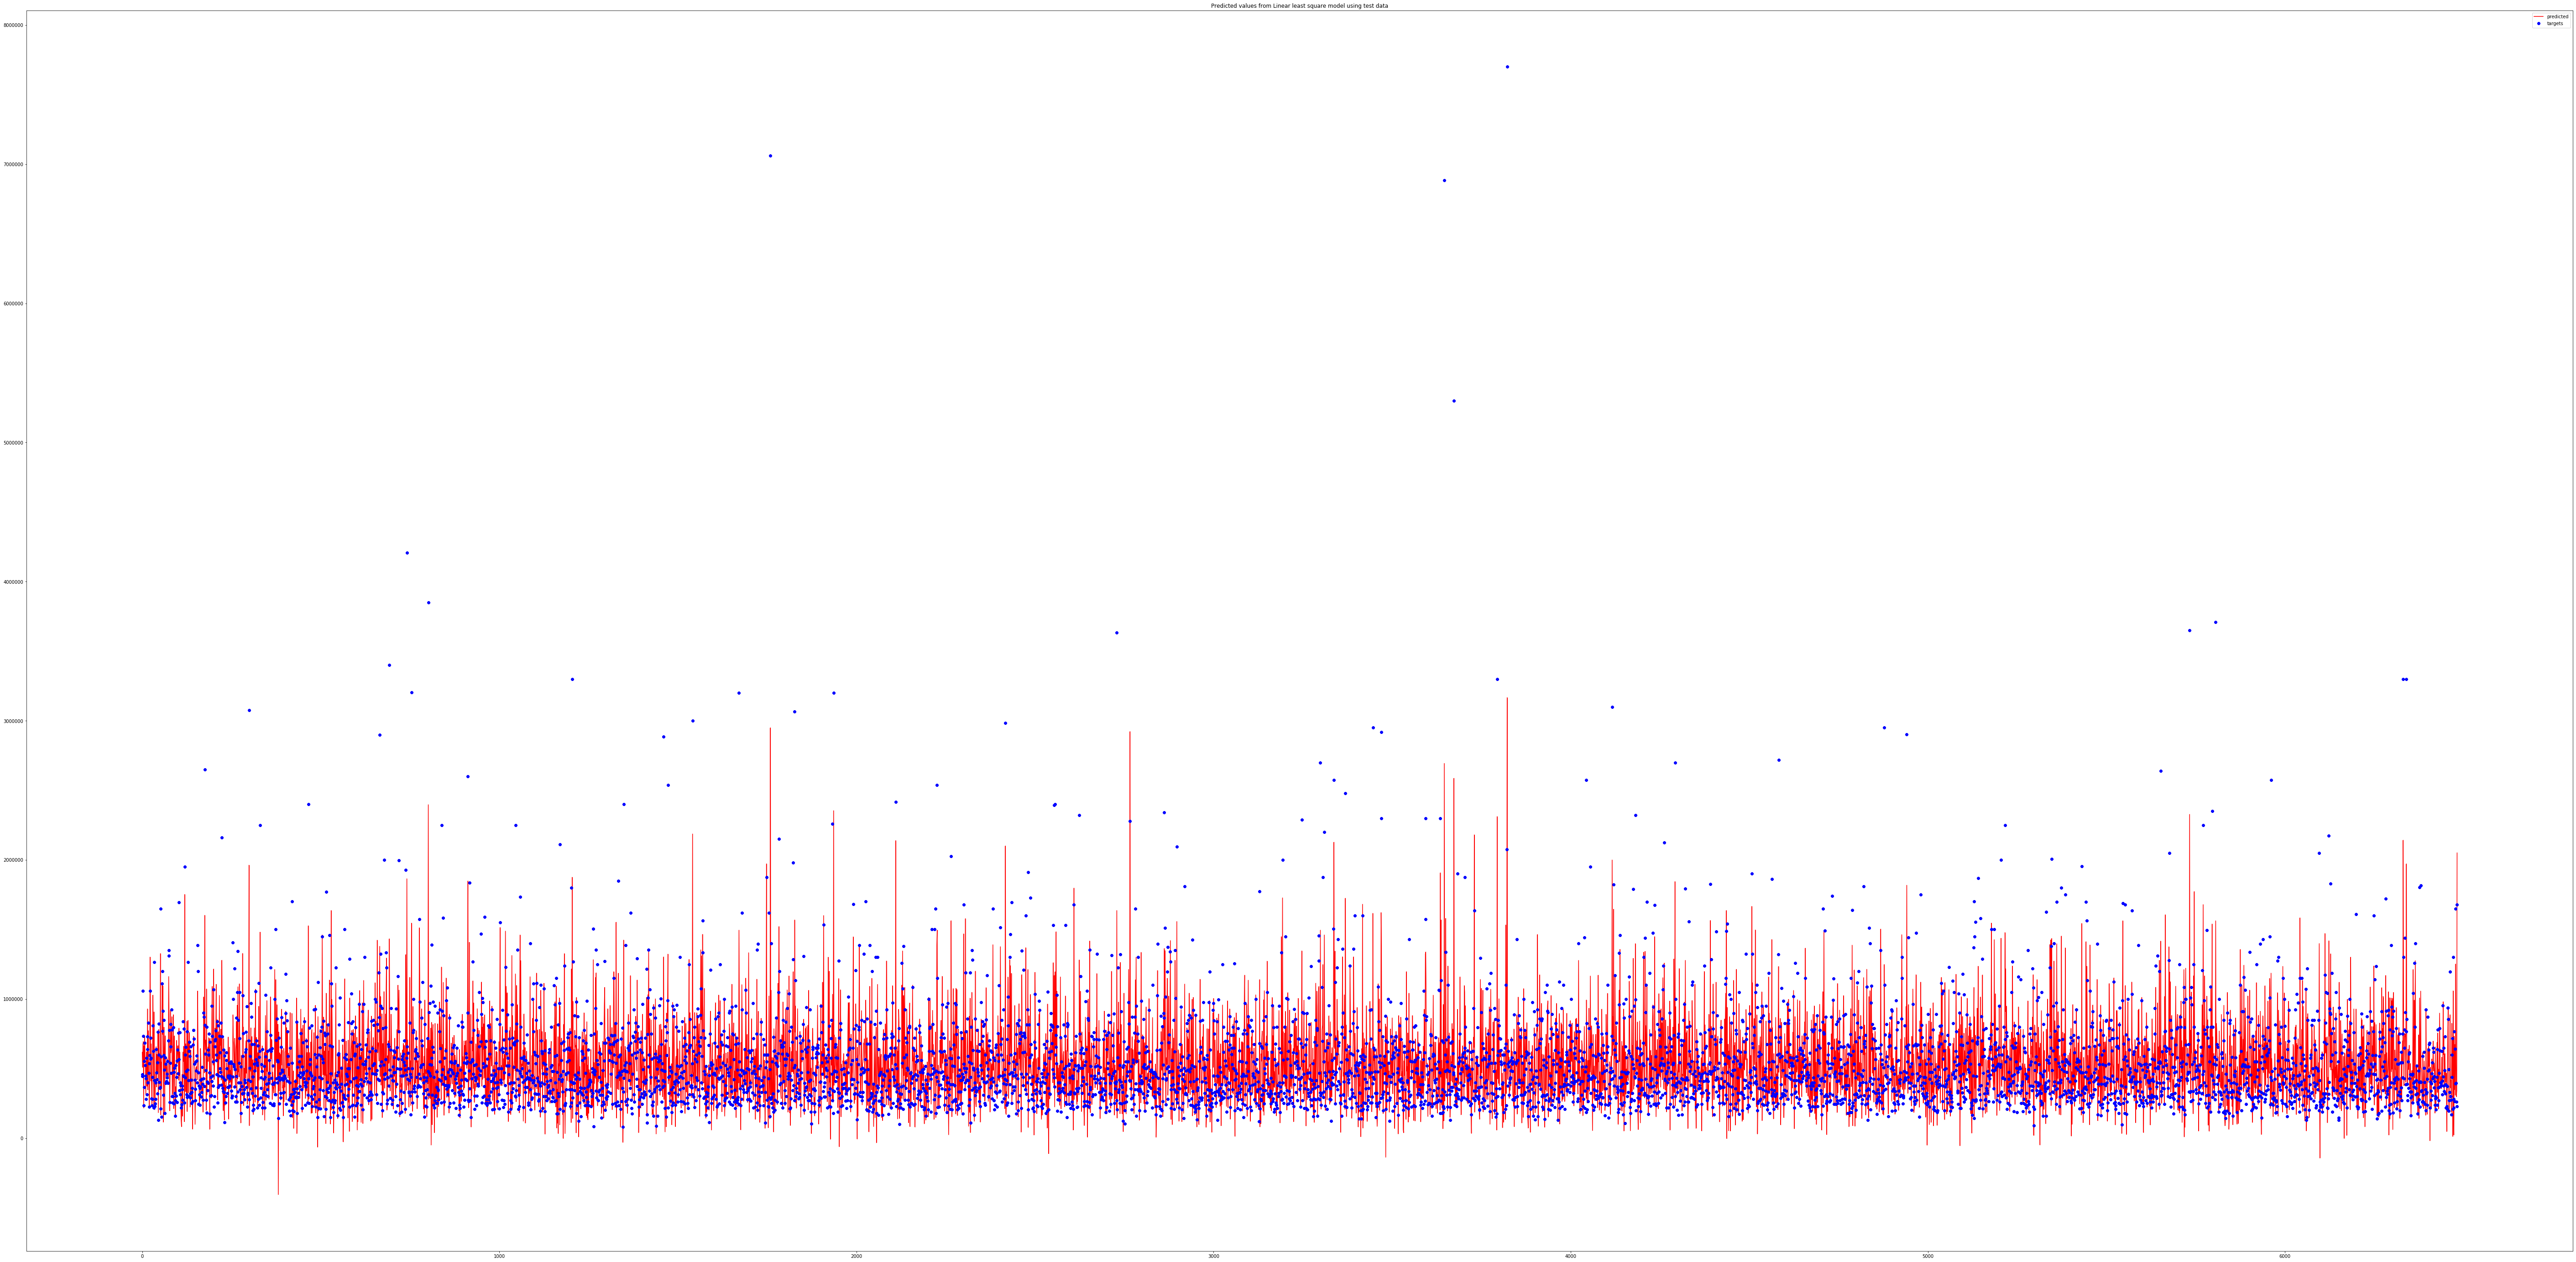

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(100,50))
#plt.plot(pred_sk, '-y', label= "sk-learn")
plt.plot(pred_ls, 'r', label="predicted")
plt.plot(T_test, 'b8', label="targets")
plt.title("Predicted values from Linear least square model using test data")
plt.legend()
plt.show()

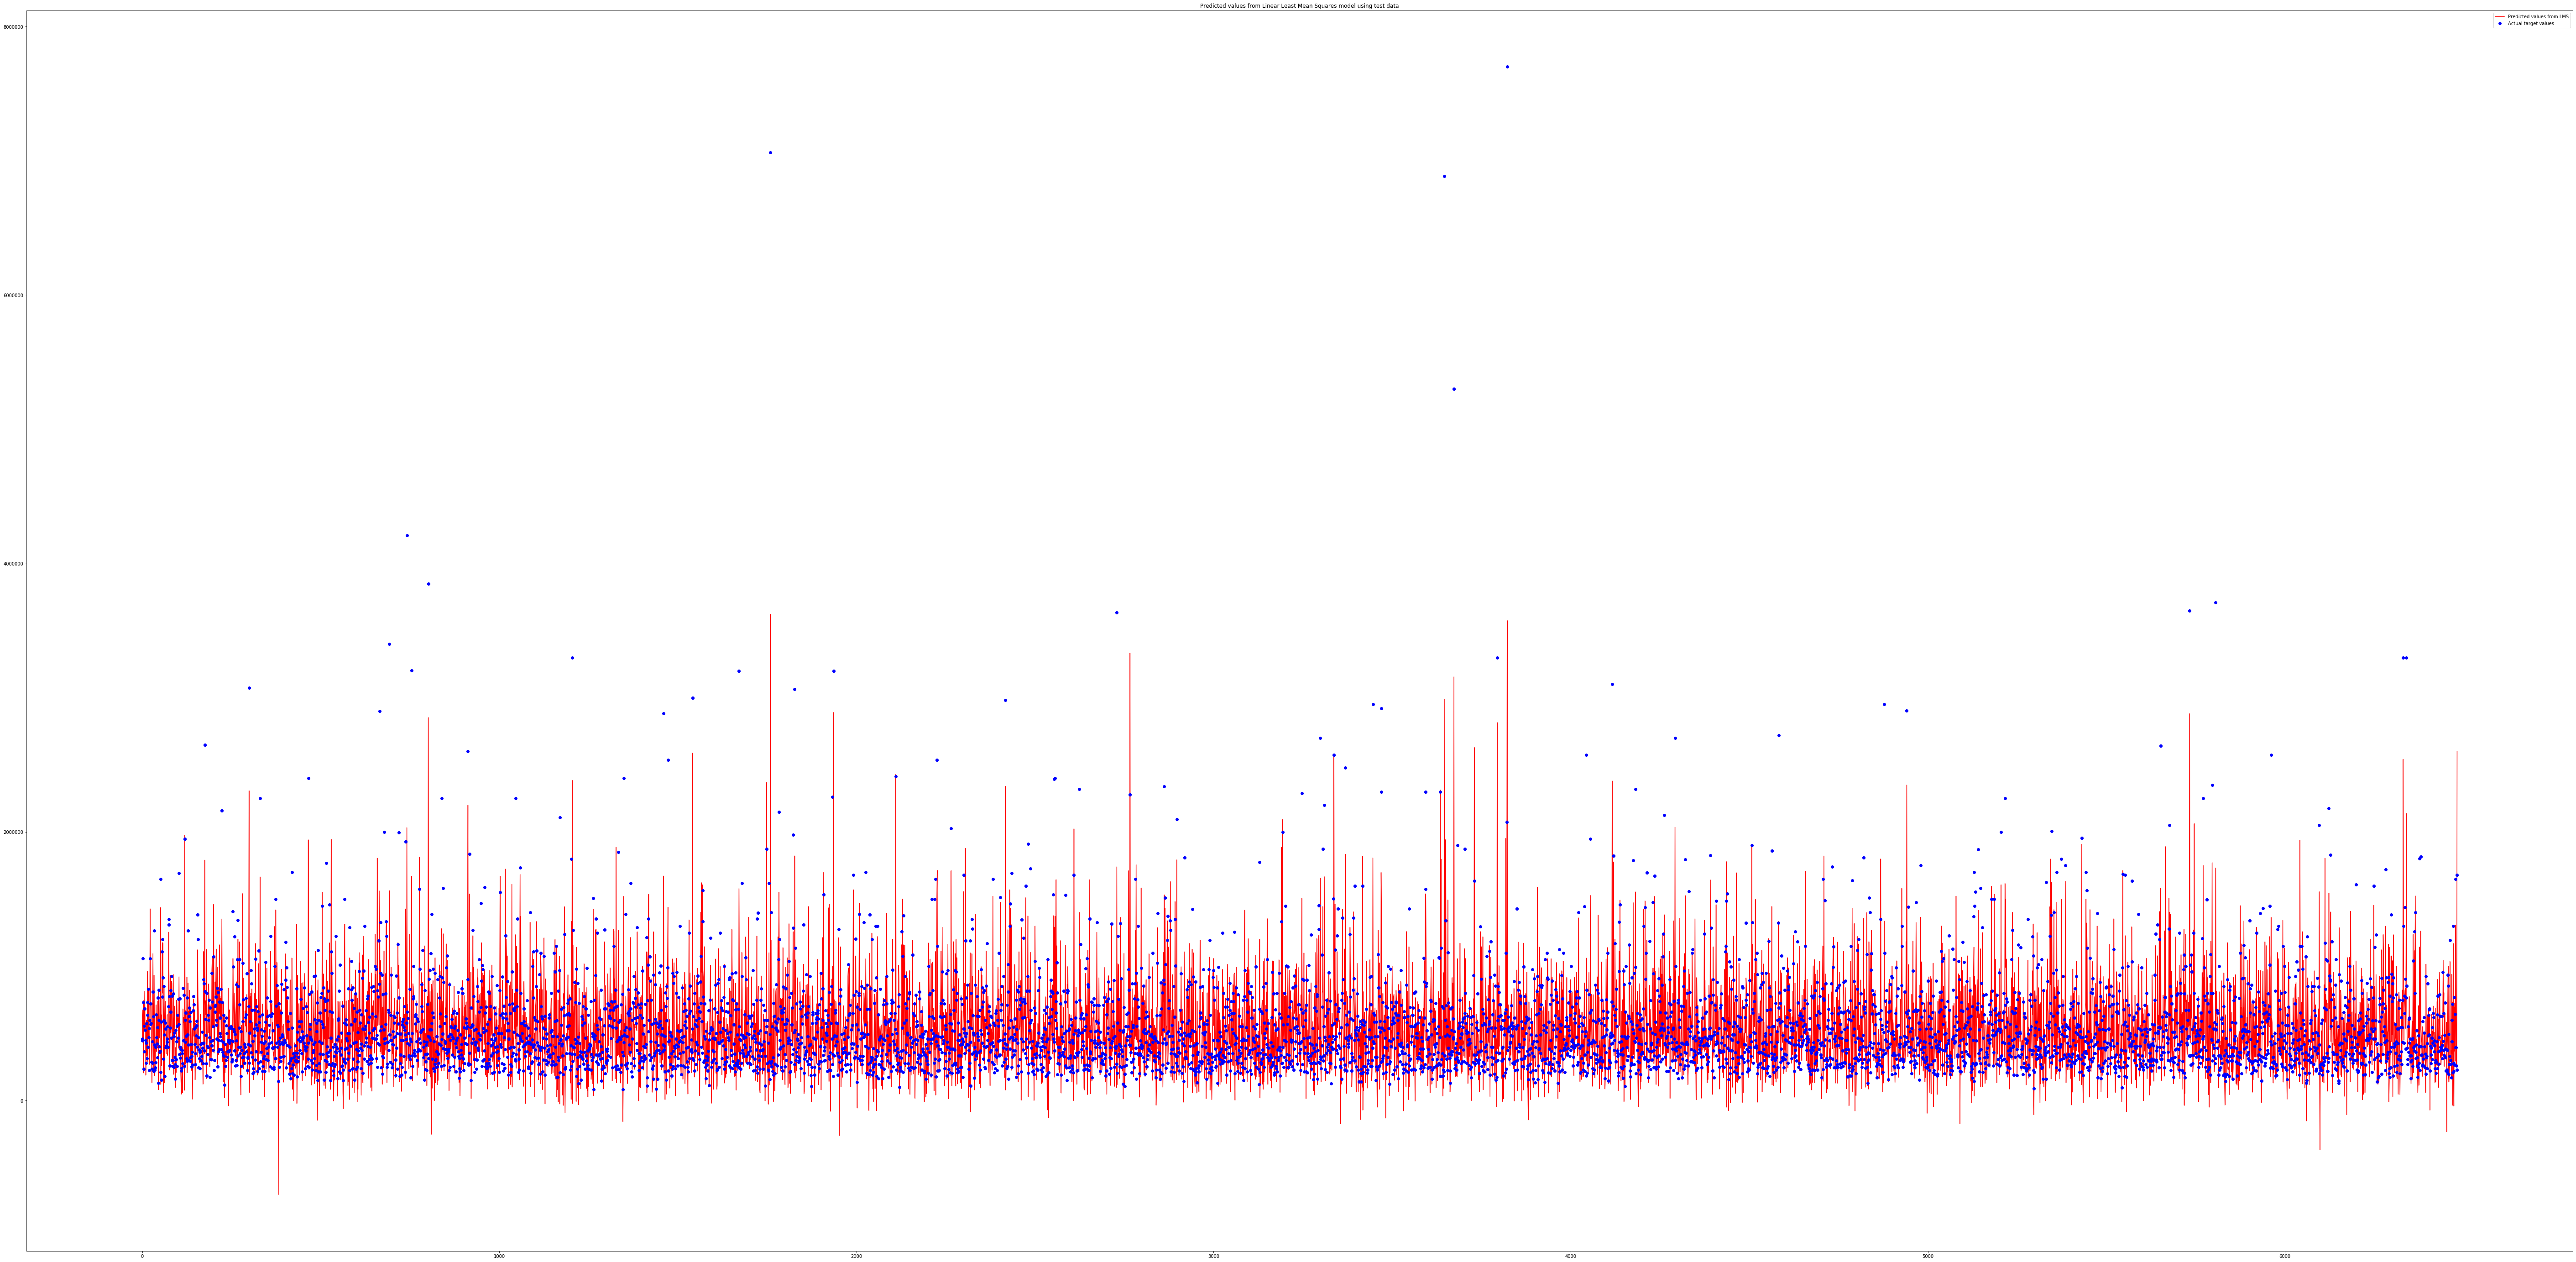

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(100,50))
plt.plot(pred_lms, 'r', label='Predicted values from LMS')
plt.plot(T_test, 'b8', label='Actual target values')
plt.legend()
plt.title("Predicted values from Linear Least Mean Squares model using test data")
plt.show()

# Least Squares V/S Least Mean Squares

The goodness of fit of the two models are measured and compared using Residual Standard Error (RSE). RSE gives the lack of fit of the model. ie., the model with the smaller RSE better fits the data (test data). $$ RSE = \sqrt{(\frac{1}{n-2}) \sum_{i=1}^{n} (y_{i} - \hat{y_{i}})^2} $$

Shown below, LMS model has smaller RSE (223229.63) than the LS model (223967.83), so LMS fits the data better than LS for the given test dataset.

In [24]:
def get_RSE(error, n):
    res = np.square(error)
    res = np.sum(res)
    res = res/(n-2)
    return np.sqrt(res)
    
    

In [25]:
error_ls = T_test - pred_ls
RSE_ls = get_RSE(error_ls, error_ls.shape[0])

In [26]:
error_lms = T_test - pred_lms
RSE_lms = get_RSE(error_lms, error_lms.shape[0])

In [27]:
RSE_ls

223967.8290878749

In [28]:
RSE_lms

223229.62977905644

# Conclusions

- Although, linear regression does not require that the features be in the same scale. Normalization is necessary when using stochastic gradient desent to compute Least Mean Squares, to make sure that the gradient function is bounded.
- Regularization decreases the goodness of fit of the model, hence is a great tool for avoiding over-fitting.

# References


1. I. Goodfellow, Y. Bengio, and A. Courville,Deep learning.
2. A. M. C. S. Guido,Introduction to Machine Learning with Python.   O’Reilly Media, Inc,2016.
3. F. Chollet,Deep learning with Python

The features with a high weight is believed to be most significantly influencing our prediction and the feature with lowest weight would be the least important feature in the predictions

In [29]:
cols = data_train_independent.columns.to_numpy()
cols = np.insert(cols, 0, 'intercept')
cols

array(['intercept', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat',
       'long', 'sqft_living15', 'sqft_lot15'], dtype=object)

In [30]:
weights_ls = ls.weights()

In [31]:
w_ls_df = pd.DataFrame(columns=["features","weights"])
w_ls_df["features"] = cols
w_ls_df["weights"] = weights_ls
w_ls_df.sort_values(by="weights", ascending=False )

,features,weights
0,intercept,537679.170126
10,sqft_above,181151.380988
9,grade,103985.264959
15,lat,85294.950825
11,sqft_basement,73707.943785
2,bathrooms,66087.518349
6,waterfront,48119.176733
7,view,41982.030454
8,condition,20084.357411
17,sqft_living15,13238.227545


__Feature "sqft_above" is the most significant feature and "yr_built" is the least significant feature__

### Removing the most significant feature "sqft_above" and the least significant feature "yr_built"

In [32]:
data_train_independent_regu = data_train.drop(columns=["price","date","id", "sqft_above", "yr_built"])
data_train_dependent_regu = data_train[["price"]]
data_test_independent_regu = data_test.drop(columns=["price","date","id", "sqft_above", "yr_built"])
data_test_dependent_regu = data_test[["price"]]

In [33]:
data_train_independent_regu = (data_train_independent_regu-data_train_independent_regu.mean())/data_train_independent_regu.std()
data_test_independent_regu = (data_test_independent_regu-data_test_independent_regu.mean())/data_test_independent_regu.std()

In [34]:
T_train_regu = data_train_dependent_regu.to_numpy()
X_train_regu = data_train_independent_regu.to_numpy()

In [35]:
T_test_regu = data_test_dependent_regu.to_numpy()
X_test_regu = data_test_independent_regu.to_numpy()

In [36]:
## Fitting the LS model

ls_regu = LinearRegress()
ls_regu.train(X=X_train_regu, T=T_train_regu)
pred_ls_regu = ls_regu.use(X_test_regu)
pred_ls_regu

array([[ 619739.49289865],
       [ 515564.11042827],
       [ 667175.16130497],
       ...,
       [ 313574.79471282],
       [ 250494.19196246],
       [2139648.61945282]])

In [37]:

error_regu = T_test_regu - pred_ls_regu
RSE_regu = get_RSE(error_regu, error_regu.shape[0])

In [38]:
RSE_regu

227267.94593913428

The RSE changed from 223967.83 to 227267.95 after dropping the most and lest significant features. The increase in RSE shows that the model fit has decreased after dropping the above two features. The model is plotted below against the observed test values.

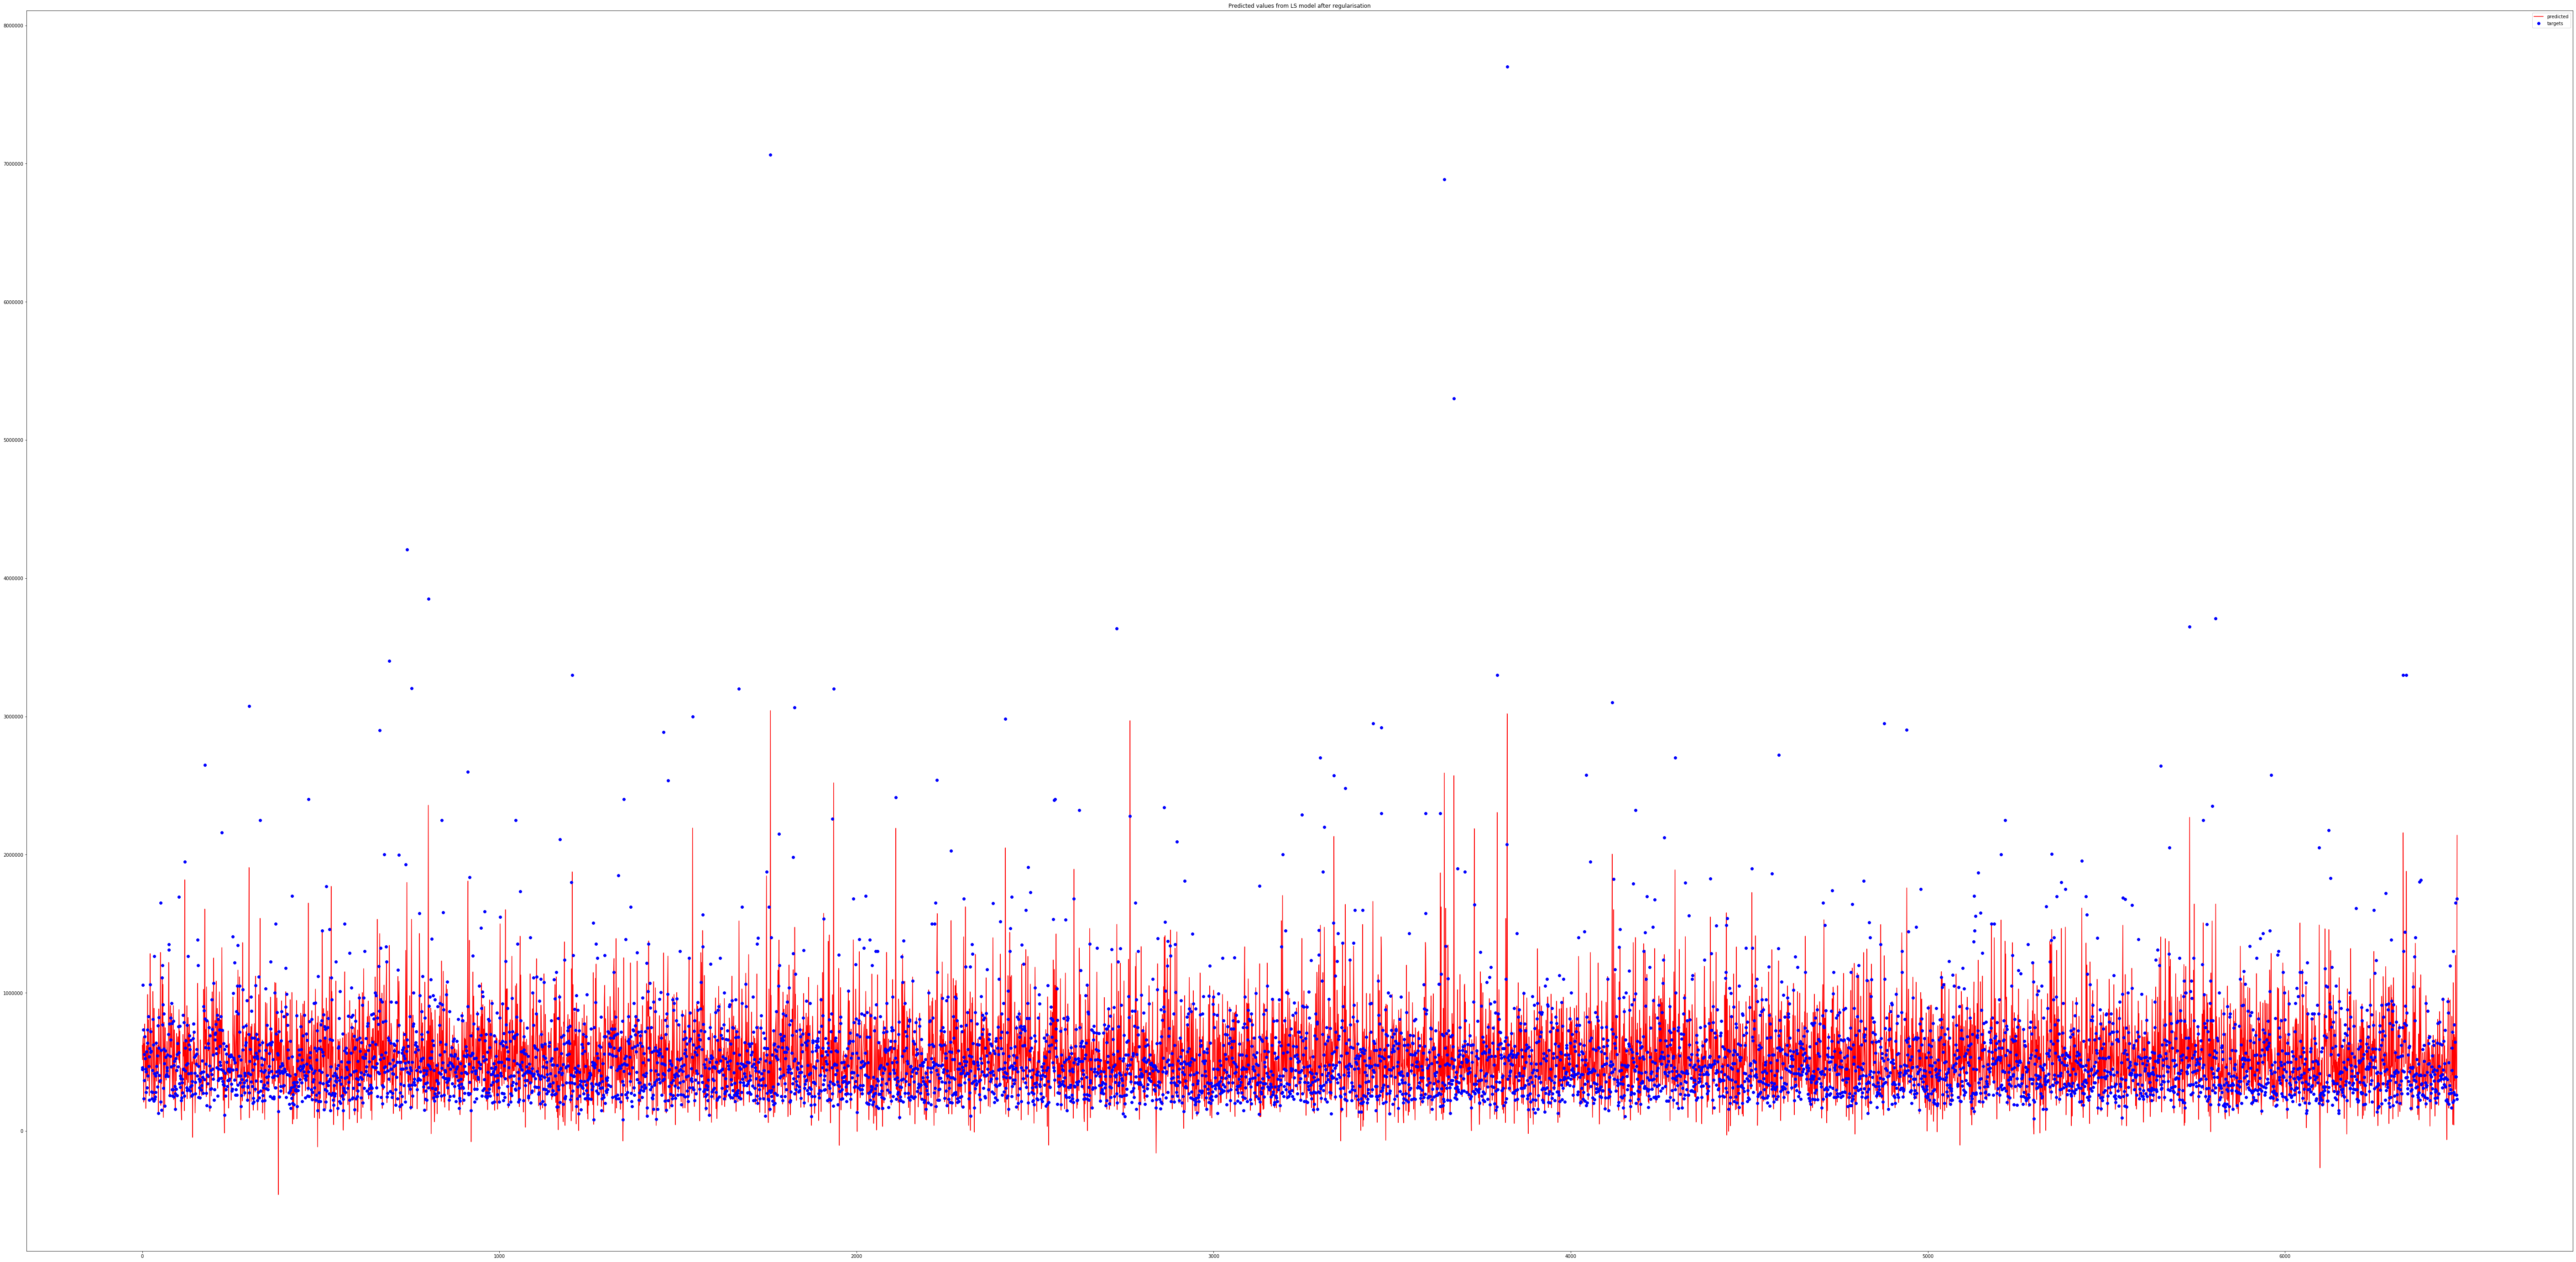

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(100,50))
#plt.plot(pred_sk, '-y', label= "sk-learn")
plt.plot(pred_ls_regu, 'r', label="predicted")
plt.plot(T_test_regu, 'b8', label="targets")
plt.title("Predicted values from LS model after regularisation")
plt.legend()
plt.show()

## Residual Plots 

### Residual plot for Least Squares model

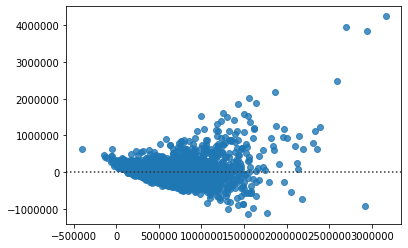

In [40]:
import seaborn as sns
sns.residplot(pred_ls, error_ls)


### Residual plot for Least Mean Squares model

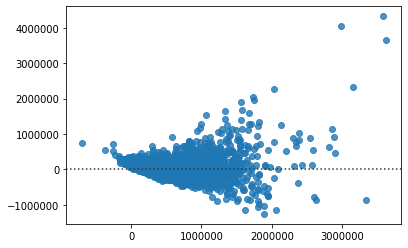

In [41]:
sns.residplot(pred_lms, error_lms)

### Residual plot for regularized model

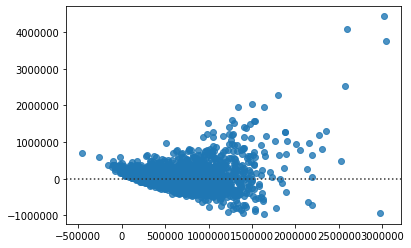

In [42]:
sns.residplot(pred_ls_regu, error_regu)

## Grading

DO NOT forget to submit your data! Your notebook is supposed to run well after running your codes. 

** Note: this is a WRITING assignment. Proper writing is REQUIRED. Comments are not considered as writing. ** 


Points | | Description
--|--|:--
5 | Introduction  
20 | Data | 
 | 5| description 
 | 5| plots for understanding or analysis 
 | 5| preliminary observation 
 | 5| Preprocessing of the data 
40 | Method | 
 | 5| review
 | 5| explanation of codes
 | 30| Correct implementation (preliminary test)
30 | Experiments | 
 | 5| description, codes
 | 10| visualization of results
 | 15| analysis / comparison of algorithms
5 | Conclusions, References 

# Preliminary Test

After finishing the implmentation of LinearRegress and LMS classes, run the following cell to test if your implementation is correct. Make sure and check your codes to pass all three tests as in sample outputs. 

In [190]:
##################### WHAT I WILL RELEASE ############

# Self-Test code for accuracy of your model - DO NOT MODIFY THIS
# Primilnary test data
X = np.array([[2,5],
              [6,2],
              [1,9],
              [4,5],
              [6,3],
              [7,4],
              [8,3]])
T = X[:,0, None] * 3 - 2 * X[:, 1, None] + 3
N = X.shape[0]

def rmse(T, Y):
    return np.sqrt(np.sum((T-Y)**2))

model_names = ['LS', 'LMS_All', 'LMS_1STEP']
models = [LinearRegress(), LMS(0.02), LMS(0.02)]
# model_names = ['LS']
# models = [LinearRegress()]


#train
for i, model in enumerate(models):
    print("training ", model_names[i], "...") 
    if i == len(models) -1: 
        # train only one step for LMS2
        model.train_step(X[0], T[0])
    else:
        model.train(X, T)

def check(a, b, eps=np.finfo(float).eps):
    if abs(a-b) > eps:
        print("failed.", a, b)
    else:
        print("passed.")

errors = [1.19e-13, 2.8753214702, 38.0584918251]
for i, model in enumerate(models):
    print("---- Testing ", model_names[i], "...", end=" ") 
    
    # rmse test
    err = rmse(T, model.use(X))
    if check(err, errors[i], eps=1e-10):
        print ("check your weights: ", model.w)
        print ("oracle: ", )


training  LS ...
training  LMS_All ...
[-0.02 -0.04 -0.1 ]
0
[0.3292 2.0552 0.5984]
1
[-0.0662  1.6598 -2.9602]
2
[ 0.19836  2.71804 -1.6374 ]
3
[ 0.266472  3.126712 -1.433064]
4
[ 0.258048  3.067744 -1.46676 ]
5
[ 0.2700536  3.1637888 -1.4307432]
6
training  LMS_1STEP ...
---- Testing  LS ... passed.
---- Testing  LMS_All ... passed.
---- Testing  LMS_1STEP ... passed.
